In [4]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, STOPWORDS
import nltk
nltk.download("wordnet")

from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases

import crear_modelo_config

if __name__ == "__main__":
    ml_dataset = pd.read_csv("TweetsTrainDev.csv")
    ml_dataset.drop(ml_dataset[ml_dataset["airline"] != "United"].index, inplace = True)
    ml_dataset.drop(ml_dataset[ml_dataset["airline_sentiment"] != "negative"].index, inplace = True)

    docs = list(ml_dataset["text"])
    original_docs = docs[:]
    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')

    stopwords = STOPWORDS.union(frozenset(["ua", "we", "on", "me", "you"])).difference(["kg", "before", "over", "system", "serious", "off", "take", "nowhere", "found"])
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = remove_stopwords(docs[idx], STOPWORDS)
        docs[idx] = strip_punctuation(docs[idx])
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words."""

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]

    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=20, no_above=0.1)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    # Set training parameters.
    #num_topics = 12
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    models = []
    for num_topics in range(2, 30):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every # type: ignore
        )
        models.append(model)

    #diccionario = Dictionary(ml_dataset.Tokens)

[nltk_data] Downloading package wordnet to /home/diego/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Number of unique tokens: 245
Number of documents: 2633


In [20]:
coherences = []
num_top_arr = []

num_topics = 2
for model in models:
        top_topics = model.top_topics(texts=docs, dictionary=dictionary, coherence="c_v")
        # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
        avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
        #print('Average topic coherence: %.4f.' % avg_topic_coherence)

        coherences.append(avg_topic_coherence)
        num_top_arr.append(num_topics)
        print(f"num_topics: {num_topics}, avg_coherence: {avg_topic_coherence}")
        num_topics += 1

num_topics: 2, avg_coherence: 0.2061275292751723
num_topics: 3, avg_coherence: 0.2679790684269109
num_topics: 4, avg_coherence: 0.249488824715838
num_topics: 5, avg_coherence: 0.24995323388263352
num_topics: 6, avg_coherence: 0.23823834849222494
num_topics: 7, avg_coherence: 0.2631357967369502
num_topics: 8, avg_coherence: 0.2652265114785607
num_topics: 9, avg_coherence: 0.27839870382772347
num_topics: 10, avg_coherence: 0.30415473394098425
num_topics: 11, avg_coherence: 0.2894650907839042
num_topics: 12, avg_coherence: 0.32547755189672367
num_topics: 13, avg_coherence: 0.35066820498382306
num_topics: 14, avg_coherence: 0.31535309052354693
num_topics: 15, avg_coherence: 0.31227723448394445
num_topics: 16, avg_coherence: 0.3240977355349203
num_topics: 17, avg_coherence: 0.3351125548469759
num_topics: 18, avg_coherence: 0.3156322889415668
num_topics: 19, avg_coherence: 0.333185614242273
num_topics: 20, avg_coherence: 0.3492191832832675
num_topics: 21, avg_coherence: 0.32923015768950153
n

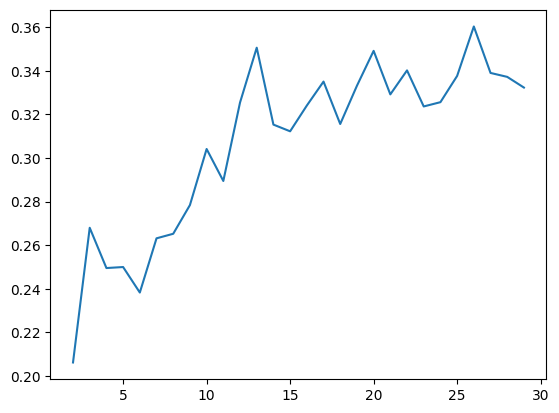

In [22]:

import matplotlib.pyplot as plt
import numpy as np

valores = np.array(coherences)
etiquetas = np.array(num_top_arr)

plt.plot(etiquetas, valores)
plt.show()
